###1.Collecting Tweets through Twitter API

Using Twitter API, we can collect information tweets includes user information, date, and tweets. For this, install and import Twitter API first.

In [0]:
!pip install python-twitter
import twitter
import json

     |████████████████████████████████| 71kB 4.6MB/s 


import keys.py file that contains twitter API user information to collect tweets from twitter

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib


Saving keys.py to keys.py


In [0]:
import keys
api = twitter.Api(consumer_key = keys.consumer_key,
                 consumer_secret = keys.consumer_secret,
                 access_token_key = keys.access_token,
                 access_token_secret = keys.access_token_secret)

In [0]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
  name = fn, length = len(uploaded[fn])))

Saving drug_safety_data.txt to drug_safety_data.txt
User uploaded file "drug_safety_data.txt" with length 185065 bytes


Tweets ids and twitter user ids are in 'drug_safety_data.txt' file. 

1. Collect tweets information that we will refer through twitter API
2. The data are stored as json format
3. Text in below shows how it is constructed 



In [0]:
import pandas as pd
drugTweets = pd.read_csv('drug_safety_data.txt', delimiter = '\t', header = None, names = ['tweet_id', 'twitter_user_id', 'abuse'])
drugTweets = drugTweets.drop_duplicates()
drugTweets_text = api.GetStatuses(drugTweets.tweet_id)
txts = []
for tweet in drugTweets_text:
  txts.append(json.loads(json.dumps(tweet._json)))
txts[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sun May 12 18:08:41 +0000 2013',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 333644914913079296,
 'id_str': '333644914913079296',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'text': 'i know for a FACT that alcohol does not deplete the seroquel levels in your blood, YET HERE WE ARE',
 'truncated': False,
 'user': {'contributors_enabled': False,
  'created_at': 'Fri Dec 24 03:45:56 +0000 2010',
  'default_profile': False,
  'default_profile_image': False,
  'description': 'revive prime suspect (2011 - 2012)',
  'enti

From the json format, take out necessary information such as user_ids and texts

In [0]:
ids = []
text = []
for line in txts:
  ids.append(line['id'])
  text.append(line['text'])

###2.Text pre-processing

Tweets were written in the informal language in most cases, and included reserved words related to Twitter. To improve machine learning models performance, it is required to clean unnecessary text up to teach models clearly. 

####1.Remove Twitter reserved word

In [0]:
!pip install tweet-preprocessor
import preprocessor as p

  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7946 sha256=d7bdb1b8e01bb419d1466c4c846844d6f8e02e65bf0986cc5814632499f7228f
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor


tweet-preprocessor library supports to remove these text.


1.   URLs
2.   Hashtags
3.   Mentions
4.   Reserved words (RT, FAV)
5.   Emojis
6.   Smileys
7.   Number

In [0]:
text_clean = []
for line in text:
  text_clean.append(p.clean(line))
print('Before : {}'.format(text[1]))
print('After  : {}'.format(text_clean[1]))

Before : @Scribble_Dragon 50 mg Seroquel with my ‘normal’ 60 mg Lovan and 750 mcg Clonazepam.
After  : mg Seroquel with my ‘normal’ mg Lovan and mcg Clonazepam.


After cleaning twitter reserved words, put this on the data frame that includes tweet_id, user_id and classfication label information.

In [0]:
tweets_w_text = pd.DataFrame(list(zip(ids, text_clean)), columns = ['tweet_id', 'text_text'])
drugTweets_df = pd.merge(tweets_w_text, drugTweets, on = 'tweet_id', how = 'inner')

####2.Stopwords / Lowercase / Stemming

Besides removing Twitter words, we can remove stopwords that would not give important information and lowercase every text for avoiding counting same words several times. Also, we decide to apply stemming to reduce inflected words to their word stem.

In [0]:
import nltk
import re
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'fix_text' function includes removing stopwords, stemming, lowercasing and removing special characters. 

In [0]:
stop_words = set(stopwords.words("english"))
snow = nltk.stem.SnowballStemmer('english')

def fix_Text(text):
	letters_only = re.sub("[^a-zA-Z]"," ", str(text))
	words=letters_only.lower().split()
	meaningful=[snow.stem(word) for word in words if word not in stop_words]
	return(" ".join(meaningful))

In [0]:
num_resp = drugTweets_df["text_text"].size
print("Before : {}".format(drugTweets_df['text_text'][2]))
clean_text = []
for i in range(0,num_resp):
	clean_text.append(fix_Text(drugTweets_df["text_text"][i]))

print("After : {}".format(clean_text[2]))

Before : SEVEN missed calls? get you're seroquel mg lowered. you're getting ridiculous
After : seven miss call get seroquel mg lower get ridicul


Also we found that twitter users use two words for one medicine such and also they type energy drink 'red bull' or 'redbull'. We thought it is reasonable to count these words together. Also, even we removed special characters, broken codes are still in text such as 'amp', 'lt,' and 'gt' because thoese are alphabet characters. So we made a function that change specific words, and remove the broken codes. 

In [0]:
word_list = {'quetiapin' : 'seroquel', 'oxycontin' : 'oxycodone', 'red bull' : 'redbull', 'amp':'', 'lt':'', 'gt':''}

def change_word(text):
  for key in list(word_list.keys()):
    if key in text:
      text = text.replace(key, word_list[key])

  return text

In [0]:
print("Before : {}".format(clean_text[5]))
for i in range(num_resp):
  clean_text[i] = change_word(clean_text[i])

print("After : {}".format(clean_text[5]))

Before : antipsychot quetiapin sedat olanzapin risperidon aripiprazol lithium augment agent
After : antipsychot seroquel sedat olanzapin risperidon aripiprazol lithium augment agent


###3.Document - Term representation

In order to classify tweets by machine learning models, we need to create a document-term representation. Numbers in the matrix represent how important a word is to a document in a collection or corpus.

##### 1.Term Frequency

Using by CountVectorizer function, we can tokenize and count the frequency of words in tweets. After it, fit_transform module creats a Document-Term matrix. 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
tfVectorizer=CountVectorizer()
tfdtm= tfVectorizer.fit_transform(clean_text)
tfVectorizer.get_feature_names()[0:5]

['abbi', 'abid', 'abil', 'abilifi', 'abl']

#### 2.Term Frequency - Inverse Document Frequency (Feature Selection)

The frequency of words does not tell us how the words important, because some not important words such as 'I', 'the', 'a' would frequently appear than other terms. Term Frequency - Inverse Document Frequency value represents priority by the number of appearance in the document / the number of occurrence in the corpus. 

TfidfVectorizer module helps create tfidf matrix and set the minimum number of appearance. After creating the counting vector, convert it to data frame that we are going to use it for classification modeling.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

We then created 3 datasets where only the terms that appeared a minimum of 20, 30 and 50 times respectively would be included. With the minimum term appearance of 20, 226 features were retained for a minimum of 30 terms, 137 features were retained, and with a minimum of 50 term appearances, 67 features were retained. 

We evaluated the result of each frequency before, and 30 reveals the best performance. Thus, we decide to set minimum frequency of words ad 30 here. 

In [0]:
tfidfVectorizer=TfidfVectorizer(min_df=30)
tfidfdtm = tfidfVectorizer.fit_transform(clean_text)
tfidfVectorizer.get_feature_names()[0:5]

['actual', 'adderal', 'addict', 'also', 'ask']

In [0]:
tfidf_df = pd.DataFrame(tfidfdtm.toarray(), columns=tfidfVectorizer.get_feature_names())
tfidf_df[:10]

,actual,adderal,addict,also,ask,ass,back,bad,bed,best,better,call,caus,coffe,come,could,day,doctor,done,dose,drink,drug,eat,effect,even,ever,everi,feel,final,find,first,focus,friend,fuck,gave,get,give,go,gonna,good,...,shit,sinc,sleep,someon,someth,start,stay,still,stop,studi,sure,surgeri,take,taken,talk,tell,thank,thing,think,thought,time,today,tomorrow,tonight,took,tri,two,use,wake,wanna,want,way,week,well,without,work,would,xanax,yeah,year
0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.532974,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.696834,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.00000,0.0,0.0,0.69535,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.16467,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269218,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.448937
5,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
6,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.494662,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
7,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.445602,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.747859,0.0,0.0,0.000000
8,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.45356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444197,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.46185,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.459702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [0]:
drugTweets_df

,tweet_id,text_text,twitter_user_id,abuse
0,333644914913079296,i know for a FACT that alcohol does not deplet...,230052171,0
1,344825926342832128,mg Seroquel with my ‘normal’ mg Lovan and mcg ...,179074771,0
2,333854289023864832,SEVEN missed calls? get you're seroquel mg low...,333099736,0
3,344606561873833985,there's a fella on my Facebook who is asking t...,464202509,1
4,341947615853813761,you take vyvanse? I was on that stuff for like...,90304006,0
5,328655421256654849,antipsychotics: quetiapine (sedation); olanzap...,1371093139,0
6,333735685406224385,I take quetiapine and it's supposed to just re...,38919907,0
7,344937940146855937,Seroquel is pretty heavy stuff. I would've tho...,185070700,0
8,342112352130449409,Tell me why this kid just gave me six seroquel...,345065773,0
9,341680382179160065,look at the tweet near that one. I refuse to t...,38971420,0


In [0]:
tfidf_df['abused'] = drugTweets_df.abuse

###4.Modeling

Data set for modeling is made through text pre-processing and creating a tf-idf matrix. In this part, we will focus on how to make classfication models.

####1.Import classifiers

Importing classification model packages.

We will train KNN, SVM, Naive Bayes, and Decision tree models, and compare performance.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

####2.Load DTM File and split as train & test

Use a tf-idf matrix that we made above as dataset.

1.   Take a label column in dataset as y.
2.   Split dataset as training and test set. (Training 80% / Test 20%)



In [0]:
X = tfidf_df.drop('abused', axis = 1)
y = tfidf_df.abused


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

Check how many abuse tweets do we have on our dataset.

0 is not abused one, and 1 is abused. So, we have about 15% of tweets that were labeled as abused.

We can tell it is imbalanced dataset. 

In [0]:
tfidf_df.abused.value_counts()

0    2534
1     441
Name: abused, dtype: int64

####3.Resampling

If we train models with imbalanced data, the models will be biased to predict majority class which is not aligned to the purpose of this study. In order to resolve this problem, we executed resamplings to make dataset balanced.

We will apply 3 types of resampling and pick the best one.


1. Random Over Sampling
2. Random Under Sampling
3. SMOTE



In [0]:
from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

Oversampling  (X_train_up, y_train_up)


In [0]:
ros = RandomOverSampler(random_state = 123)
X_train_up, y_train_up = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_up).items()))

[(0, 2029), (1, 2029)]


SMOTE (X_train_SMOTE, y_train_SMOTE)

In [0]:
X_train_SMOTE, y_train_SMOTE = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_SMOTE).items()))

[(0, 2029), (1, 2029)]


Undersampling (X_train_under, y_train_under)

In [0]:
rus = RandomUnderSampler(random_state = 123)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_under).items()))

[(0, 351), (1, 351)]


####4.Train and evaluate 


With oversampled data, we will train models, test on those and compare which classification model shows the best performance. 

Here is three functions that we made to work done easily.


*   fit_models - Training four models(KNN, SVM, Decision Tree, Naive Bayes) with oversampled data.
*   compare_model - Predict abused tweets based on the models trained on fit_models function.
*   print_result - Put training and test result as inputs and compare models peformance comfortably.



In [0]:
def fit_models(X_train, y_train):
  
  knn = KNeighborsClassifier()
  svm = SVC(kernel = 'linear', random_state = 123)
  dt = DecisionTreeClassifier(random_state = 123)
  nb = GaussianNB()

  _models = [knn, svm, dt, nb]
  
  classifiers = []
  for classifier in _models:
    classifier.fit(X = X_train, y = y_train)
    classifiers.append(classifier)
    
  return classifiers

In [0]:
def compare_models(classifiers, X, y):

  reports = []
  matrix = []
  
  for _classi in classifiers:
    _predicted = _classi.predict(X = X)
    _report = metrics.classification_report(y, _predicted)
    _matrix = metrics.confusion_matrix(y, _predicted)
    
    reports.append(_report)
    matrix.append(_matrix)
  
  return (reports, matrix)

In [0]:
def print_result(models, train_report, test_report):
  
  for model, train, test in zip(models, train_report, test_report):
    print('{:_<112}'.format(model))
    print('{}  {}  {}'.format('train',' ' * 55, 'test'))
    
    train_lines = train.split('\n')
    test_lines = test.split('\n')
    
    for train_line, test_line in zip(train_lines, test_lines):
      print(train_line + ' ' * 5 + test_line)

In [0]:
models = ['KNN', 'SVM_Linear', 'DecisionTree','NaiveBayesian']

Oversampling Result

In [0]:
_models_up = fit_models(X_train_up, y_train_up)
train_report_up, train_matrix_up = compare_models(_models_up, X_train_up, y_train_up)
test_report_up, test_matrix_up = compare_models(_models_up, X_test, y_test)

In [0]:
print_result(models, train_report_up, test_report_up)

KNN_____________________________________________________________________________________________________________
train                                                           test
              precision    recall  f1-score   support                   precision    recall  f1-score   support
     
           0       0.96      0.71      0.82      2029                0       0.87      0.63      0.73       505
           1       0.77      0.97      0.86      2029                1       0.19      0.48      0.27        90
     
    accuracy                           0.84      4058         accuracy                           0.61       595
   macro avg       0.87      0.84      0.84      4058        macro avg       0.53      0.55      0.50       595
weighted avg       0.87      0.84      0.84      4058     weighted avg       0.77      0.61      0.66       595
     
SVM_Linear______________________________________________________________________________________________________
train          

Undersampling Result

In [0]:
_models_under = fit_models(X_train_under, y_train_under)
train_report_under, train_matrix_under = compare_models(_models_under, X_train_under, y_train_under)
test_report_under, test_matrix_under = compare_models(_models_under, X_test, y_test)

print_result(models, train_report_under, test_report_under)

KNN_____________________________________________________________________________________________________________
train                                                           test
              precision    recall  f1-score   support                   precision    recall  f1-score   support
     
           0       0.72      0.70      0.71       351                0       0.89      0.51      0.65       505
           1       0.71      0.73      0.72       351                1       0.19      0.66      0.30        90
     
    accuracy                           0.72       702         accuracy                           0.53       595
   macro avg       0.72      0.72      0.72       702        macro avg       0.54      0.58      0.47       595
weighted avg       0.72      0.72      0.72       702     weighted avg       0.79      0.53      0.59       595
     
SVM_Linear______________________________________________________________________________________________________
train          

SMOTE Result

In [0]:
_models_SMOTE = fit_models(X_train_SMOTE, y_train_SMOTE)
train_report_SMOTE, train_matrix_SMOTE = compare_models(_models_SMOTE, X_train_SMOTE, y_train_SMOTE)
test_report_SMOTE, test_matrix_SMOTE = compare_models(_models_SMOTE, X_test, y_test)


print_result(models, train_report_SMOTE, test_report_SMOTE)

KNN_____________________________________________________________________________________________________________
train                                                           test
              precision    recall  f1-score   support                   precision    recall  f1-score   support
     
           0       0.95      0.67      0.78      2029                0       0.89      0.56      0.69       505
           1       0.74      0.97      0.84      2029                1       0.20      0.60      0.30        90
     
    accuracy                           0.82      4058         accuracy                           0.57       595
   macro avg       0.85      0.82      0.81      4058        macro avg       0.54      0.58      0.49       595
weighted avg       0.85      0.82      0.81      4058     weighted avg       0.78      0.57      0.63       595
     
SVM_Linear______________________________________________________________________________________________________
train          

###5.Validation

To validate our model, we run cross validation and draw ROC curve.

#### 1.Cross Validation

Since the data is imbalanced, we adopt stratifiedKFold function that keeps class weights on spliiting data for cross validation. Also, we use f1_scorer to compare models by f1_measure, not Accuracy. 

In [0]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

def cross_validation(estimators, folds, X_mat, Y_vec):
   for estimator_name, estimator_object in estimators.items():
      
    f1_scorer = make_scorer(f1_score, pos_label= 1)
    kfolds = StratifiedKFold(n_splits=folds, random_state=123, shuffle=True)
    scores = cross_val_score(estimator=estimator_object, X=X_mat, y=Y_vec, cv=kfolds, scoring = f1_scorer)
    print(f'{estimator_name:>20}: '
          f'mean f1={scores.mean():.2%}; ' +
          f'standard deviation={scores.std():.2%}')

In [0]:
estimators = {
    'knn': KNeighborsClassifier(),
    'svm': SVC(kernel='linear', random_state=123, class_weight = 'balanced'),
    'dt': DecisionTreeClassifier(random_state=123),
    'nb': GaussianNB()
}

In [0]:
X_train_oversampled = pd.DataFrame(X_train_SMOTE, columns = X_test.columns)
oversampled_x = pd.concat([X_test, X_train_oversampled])

In [0]:
y_train_oversampled = pd.Series(y_train_SMOTE)
oversampled_y = y_test.append(y_train_oversampled)

First, cross validation on oversampled data(Oversampled_training + test)

In [0]:
cross_validation(estimators, 10, oversampled_x, oversampled_y)

                 knn: mean f1=76.73%; standard deviation=2.31%
                 svm: mean f1=71.05%; standard deviation=1.61%
                  dt: mean f1=81.23%; standard deviation=2.36%
                  nb: mean f1=70.92%; standard deviation=1.48%


Second, cross validation on Original data(training + test)

In [0]:
cross_validation(estimators, 10, X, y)

                 knn: mean f1=17.79%; standard deviation=6.03%
                 svm: mean f1=34.55%; standard deviation=6.22%
                  dt: mean f1=23.45%; standard deviation=6.04%
                  nb: mean f1=30.07%; standard deviation=2.58%


In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
def svm_param_selection(X, y, nfolds):
  parameter_candidates = [
      {'C':[1,10,100,1000], 'kernel':['linear']}
  ]
  f1_scorer = make_scorer(f1_score, pos_label= 1)
  grid_search = GridSearchCV(estimator = SVC(), param_grid = parameter_candidates, cv = nfolds, scoring = f1_scorer)
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_


In [0]:
_optimized = svm_param_selection(X_train_SMOTE, y_train_SMOTE, 10)

In [0]:
_optimized

{'C': 1000, 'kernel': 'linear'}

In [0]:
svm = SVC(kernel = 'linear', C = 1000, random_state = 123)
svm.fit(X_train_SMOTE, y_train_SMOTE)
_predicted = svm.predict(X = X_test)
report = metrics.classification_report(y_test, _predicted)
print(report)


              precision    recall  f1-score   support

           0       0.92      0.66      0.77       505
           1       0.26      0.66      0.37        90

    accuracy                           0.66       595
   macro avg       0.59      0.66      0.57       595
weighted avg       0.82      0.66      0.71       595



#### 2.ROC curve

We looked at the Area Under the Curve (AUC) on a ROC graph to future compare the model performance. SVM outperforms the other models here as well.


In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np


In [0]:
classifiers = [KNeighborsClassifier(), 
               SVC(kernel='linear', random_state=123, probability=True),
               DecisionTreeClassifier(random_state=123),
               GaussianNB()]


result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
names = ['KNN', 'SVM', 'DT','GausianNB']

for idx in range(len(names)):
    model = classifiers[idx].fit(X_train_SMOTE, y_train_SMOTE)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':names[idx],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)


In [0]:
print(result_table)

  classifiers  ...       auc
0         KNN  ...  0.608702
1         SVM  ...  0.715259
2          DT  ...  0.565886
3   GausianNB  ...  0.601980

[4 rows x 4 columns]


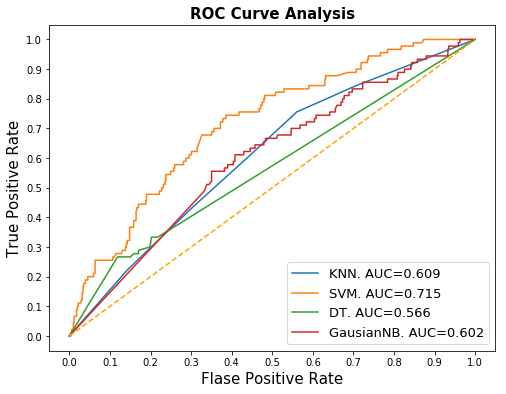

In [0]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'], 
             label="{}. AUC={:.3f}".format(result_table.loc[i]['classifiers'] ,result_table.loc[i]['auc']))


plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()